In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
import math
import cv2 as cv
import copy
from PIL import Image
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.utils import Sequence
from keras import optimizers
import pylab
from sklearn.metrics import accuracy_score
import h5py
import skimage
from skimage import transform
from keras.utils import CustomObjectScope
from keras.models import load_model
from keras import applications
from scipy import ndimage

Using TensorFlow backend.


In [39]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [40]:
Train_data = pd.read_csv('train_v2.csv')
Train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [41]:
train_ids = Train_data['image_name'].tolist()
num_train = len(train_ids)
num_train

40479

In [42]:
train_labels = Train_data['tags'].tolist()
train_labels = list(map(lambda x: x.split(' '), train_labels))
labels = [label for label_list in train_labels for label in label_list ]
labels = list(set(labels))
labels

['primary',
 'clear',
 'agriculture',
 'conventional_mine',
 'haze',
 'water',
 'partly_cloudy',
 'bare_ground',
 'blow_down',
 'blooming',
 'cultivation',
 'selective_logging',
 'habitation',
 'cloudy',
 'artisinal_mine',
 'slash_burn',
 'road']

In [43]:
num_labels = len(labels)
num_labels

17

In [44]:
label_dict = {label:num for label,num in zip(labels,range(len(labels)))}
string_to_int = lambda x: label_dict[x]
string_list_to_ints = lambda li: list(map(string_to_int, li))
train_labels =list(map(string_list_to_ints,train_labels))

In [45]:
def encode_labels(label_list):
    label_list = np.array(list(map(lambda x: np.eye(num_labels)[x],label_list)))
    label_list = np.sum(label_list,axis=0)
    return label_list

In [46]:
train_labels = list(map(encode_labels,train_labels))
train_labels = np.array(train_labels)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [47]:
trn_ids,val_ids,trn_labels,val_labels = train_test_split(train_ids,train_labels,test_size=0.1)

In [48]:
num_trn = len(trn_ids); num_val = len(val_ids);
num_trn,num_val, num_train * 0.9, num_train * 0.1

(36431, 4048, 36431.1, 4047.9)

In [49]:
train_path = './train-jpg/'

In [50]:
IMG_H, IMG_W, NUM_C = 256, 256, 3

In [51]:
mean_all=np.array([0.485, 0.456, 0.406]) ; std_all=np.array([0.229, 0.224, 0.225])

In [52]:
class train():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx),self.get_label(indx)
       
    
    def get_label(self,indx):
        
        return trn_labels[indx]
    
    def get_img(self,indx):
        img = mpimg.imread(train_path+trn_ids[indx]+'.jpg')
        img = img[:,:,0:3]
        img = (img-mean_all)/std_all
        return img
        
    
    def __len__(self):
        return num_trn

In [53]:
class valid():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx),self.get_label(indx)
       
    
    def get_label(self,indx):
        
        return val_labels[indx]
    
    def get_img(self,indx):
        img = mpimg.imread(train_path+val_ids[indx]+'.jpg')
        img = img[:,:,0:3]
        img = (img-mean_all)/std_all
        return img
        
    
    def __len__(self):
        return num_val

In [54]:
trn_img = train() 
val_img = valid()

In [55]:
class train_dl(Sequence):
    def __init__(self,bs=4):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
    
    def on_epoch_end(self):
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
        
        
    def __len__(self):
        return num_trn // self.bs
    
    def __getitem__(self,indx):
        batch = [trn_img[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask
    
  

In [56]:
class valid_dl(Sequence):
    def __init__(self,bs=4):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.arange(0,self.num_img),self.num_batch)
        
    def __len__(self):
        return num_val // self.bs
    
    def __getitem__(self,indx):
        batch = [val_img[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask

In [57]:
def make_lyrmask():
    
    data = layers.Input(shape=(IMG_H,IMG_W,NUM_C))
    
    base = applications.resnet50.ResNet50(include_top = False, weights = 'imagenet',pooling='avg' )(data)
     
    top = layers.Dense(num_labels,activation='sigmoid',use_bias = True,kernel_initializer='he_normal', 
                       bias_initializer = 'zeros')(base)
    
    resnet = Model(inputs = data, outputs = top)
    
    return resnet

In [58]:
layer = make_lyrmask()

In [59]:
layer.get_layer(index=1).trainable = False
optimizer = optimizers.Adam(lr=0.001)
layer.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])

In [60]:
trn_dl_fit=train_dl(bs=16)
val_dl_fit=valid_dl(bs=16)
layer.fit_generator(trn_dl_fit,epochs=1,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/1
2276/2276 [==============================] - 23521s 10s/step - loss: 0.1433 - accuracy: 0.9461 - val_loss: 0.7022 - val_accuracy: 0.8384


In [92]:
optimizer = optimizers.Adam(lr=0.0001)
layer.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])
trn_dl_fit=train_dl(bs=16)
val_dl_fit=valid_dl(bs=16)
layer.fit_generator(trn_dl_fit,epochs=1,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/1
2276/2276 [==============================] - 73975s 33s/step - loss: 0.1081 - accuracy: 0.9589 - val_loss: 0.1231 - val_accuracy: 0.9495


In [ ]:
layer.save('save_layer_keras_epoch.h5')

In [81]:
def plot_val(indx,TTA=False):
    val_im = val_img[indx][0]
    val_label = val_img[indx][1]
    val_im_plot = val_im * std_all + mean_all
    val_im_plot = val_im_plot.astype('int')
    plt.figure('val_im')
    plt.imshow(val_im_plot)
    if TTA is True:
        val_im_lr = np.fliplr(val_im)
        val_im_ud = np.flipud(val_im)
        val_im_lrud = np.fliplr(np.flipud(val_im))
        val_prob = layer.predict(np.array([val_im]))[0] + resnet.predict(np.array([val_im_lr]))[0] \
        + resnet.predict(np.array([val_im_ud]))[0] + resnet.predict(np.array([val_im_lrud]))[0]    
        val_prob = val_prob/4.0
    else: 
        val_prob = layer.predict(np.array([val_im]))[0] 
    val_pred = val_prob > 0.5
    print('pred:',[labels[indx] for indx in np.where(val_pred>0)[0]])
    print('label:',[labels[indx] for indx in np.where(val_label>0)[0]])

pred: ['primary', 'partly_cloudy']
label: ['primary', 'partly_cloudy']
1631


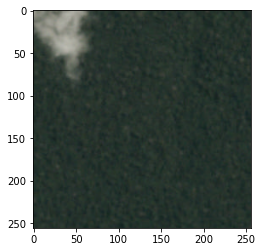

In [82]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['primary']
label: ['primary', 'agriculture', 'haze']
3375


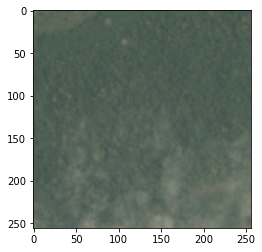

In [83]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['primary', 'partly_cloudy']
label: ['primary', 'clear', 'agriculture', 'water']
804


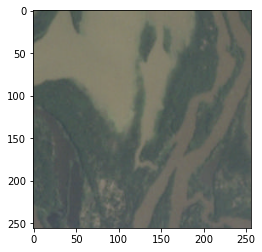

In [84]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['primary', 'cloudy']
label: ['cloudy']
889


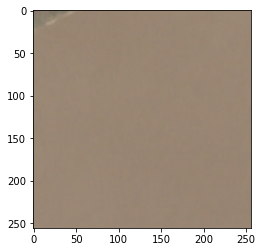

In [85]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: []
label: ['primary', 'clear']
1534


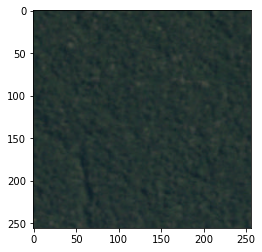

In [86]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: []
label: ['primary', 'clear']
3844


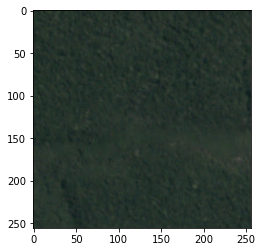

In [87]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['clear']
label: ['primary', 'agriculture', 'haze', 'road']
725


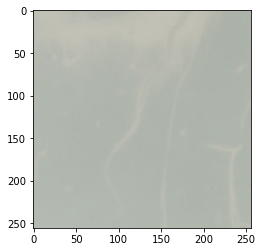

In [88]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['primary']
label: ['primary', 'clear']
2924


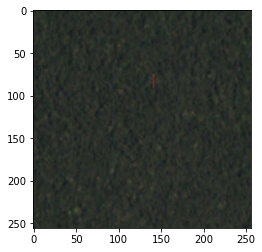

In [89]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)